# Analysis of data to build a Knowledge Graphs

In the following notebook we analyze each type of data that we need to include in the Knowledge Graphs based on the 10K patients.
The main structure of the graph will be the following:
- Data Group Nodes -> each node has embedded in it the glucose and/or sleep data of a certain patient at time interval dt.
- Patient Nodes -> one node per patient, it has embedded in it the patient's medical history at time interval dt.
- Medical Condition Nodes -> one node per medical condition, the initial embeddings are a one-hot encoded vector.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.GutMBLoader import GutMBLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.UltrasoundLoader import UltrasoundLoader
from LabData.DataLoaders.ABILoader import ABILoader
from LabData.DataLoaders.ItamarSleepLoader import ItamarSleepLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader
from LabData.DataLoaders.MedicalProceduresLoader import MedicalProceduresLoader
from LabData.DataLoaders.Medications10KLoader import Medications10KLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.DemographicsLoader import DemographicsLoader
from LabData.DataLoaders.ECGTextLoader import ECGTextLoader
from LabData.DataLoaders.DEXALoader import DEXALoader
from LabData.DataLoaders.PRSLoader import PRSLoader
from LabData.DataLoaders.HormonalStatusLoader import HormonalStatusLoader
from LabData.DataLoaders.IBSTenkLoader import IBSTenkLoader
from LabData.DataLoaders.SerumMetabolomicsLoader import SerumMetabolomicsLoader
from LabData.DataLoaders.FamilyMedicalConditionsLoader import FamilyMedicalConditionsLoader
from LabData.DataLoaders.ChildrenLoader import ChildrenLoader
from LabData.DataLoaders.MentalLoader import MentalLoader
from LabData.DataLoaders.TimelineLoader import TimelineLoader
from LabData.DataLoaders.SubjectRelationsLoader import SubjectRelationsLoader
from LabData.DataLoaders.RetinaScanLoader import RetinaScanLoader
from LabData.DataLoaders.PAStepsLoader import PAStepsLoader


/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sleep Records

ItamarSleepLoader contains the data from the sleep monitroring devices
AHI apnea hapopnea index - https://www.webmd.com/sleep-disorders/sleep-apnea/sleep-apnea-ahi-numbers

In [91]:
sl =ItamarSleepLoader().get_data()
df_sleep = sl.df

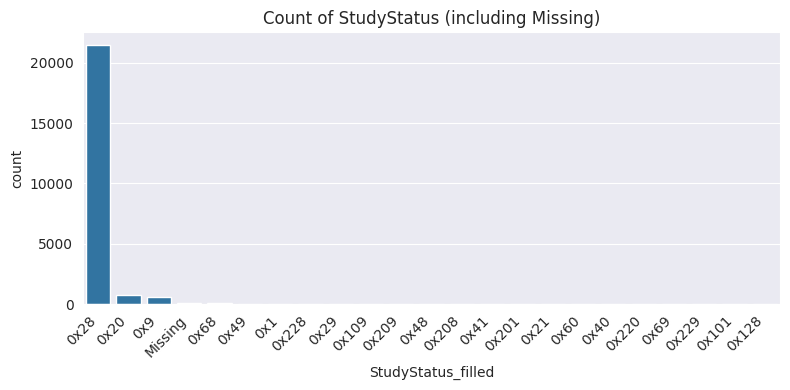

In [92]:
# 1) Fill NaN with "Missing"
df_sleep["StudyStatus_filled"] = df_sleep["StudyStatus"].fillna("Missing")

# 2) Build an ordered list of statuses that actually occur
status_counts = df_sleep["StudyStatus_filled"].value_counts()
valid_statuses = status_counts[status_counts > 0].index  # or .keys()

# 3) Plot, restricting to valid categories and rotating labels
plt.figure(figsize=(8,4))
sns.countplot(data=df_sleep, x="StudyStatus_filled", order=valid_statuses)
plt.xticks(rotation=45, ha="right")
plt.title("Count of StudyStatus (including Missing)")
plt.tight_layout()
plt.show()


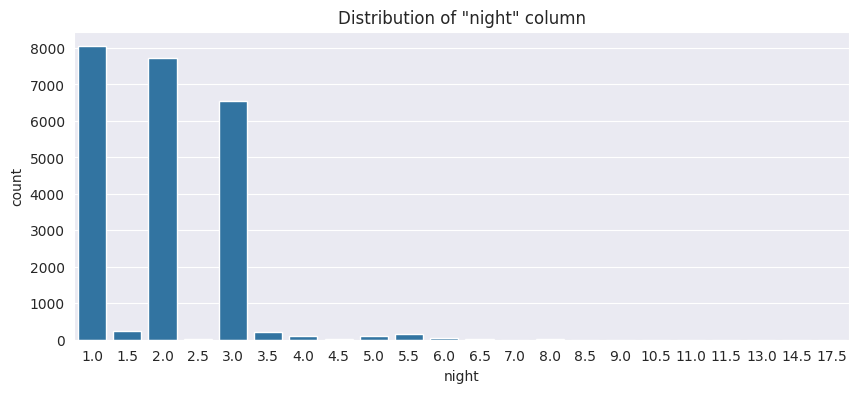

In [93]:
# In [3]:  Distribution of nights
plt.figure(figsize=(10,4))
sns.countplot(data=df_sleep, x='night')
plt.title('Distribution of "night" column')
plt.show()


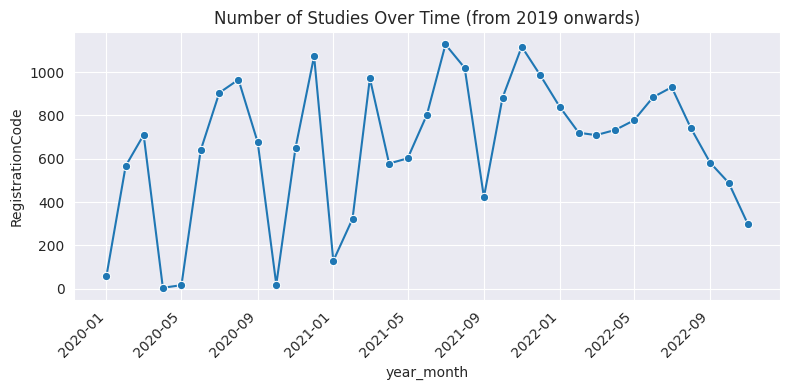

In [94]:
# In [4]: Studies over time (line plot by month)
# First convert Date to datetime, if not already
df_sleep = df_sleep.reset_index()
df_sleep['Date'] = pd.to_datetime(df_sleep['Date'], errors='coerce')

# Convert to period and then to timestamp (representing the first day of the month)
df_sleep['year_month'] = df_sleep['Date'].dt.to_period('M').dt.to_timestamp()

# Filter out dates before 2019
df_sleep = df_sleep[df_sleep['year_month'].dt.year >= 2018]

# Group by the new column and count the number of RegistrationCode entries per month
counts = df_sleep.groupby('year_month')['RegistrationCode'].count().reset_index()

# Plot the lineplot with proper rotation for clarity
plt.figure(figsize=(8, 4))
sns.lineplot(data=counts, x='year_month', y='RegistrationCode', marker='o')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Studies Over Time (from 2019 onwards)')
plt.tight_layout()
plt.show()



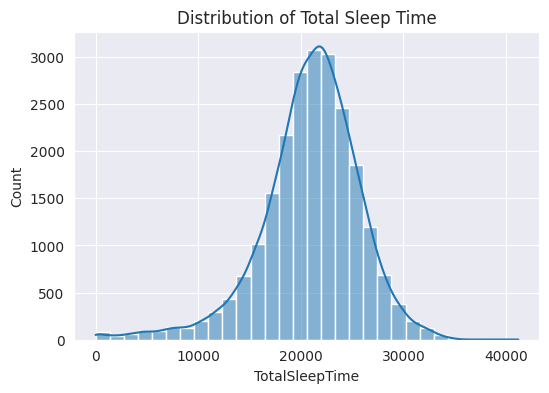

In [95]:
# In [5]:  Histogram of TotalSleepTime
plt.figure(figsize=(6,4))
sns.histplot(data=df_sleep, x='TotalSleepTime', bins=30, kde=True)
plt.title('Distribution of Total Sleep Time')
plt.show()


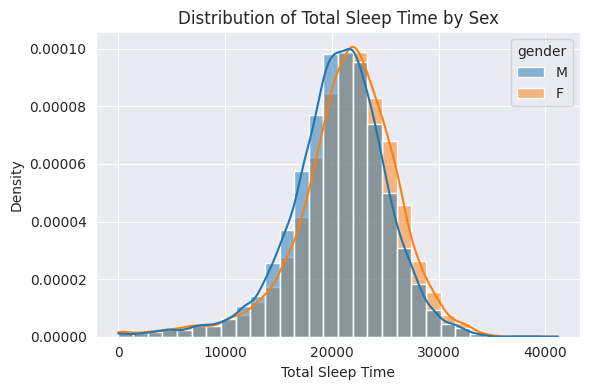

In [96]:
metadata = sl.df_metadata
metadata = metadata.reset_index()
id_gender = metadata[['RegistrationCode', 'Date', 'gender','StudyTypeID']]
# Merge the gender information into df on 'RegistrationCode'
df_sleep = df_sleep.merge(id_gender[['RegistrationCode', 'gender']], on='RegistrationCode', how='left')
# Or after merging
df_sleep['gender'] = df_sleep['gender'].map({1.0: 'M', 0.0: 'F'})

plt.figure(figsize=(6,4))
sns.histplot(
    data=df_sleep,
    x='TotalSleepTime',
    bins=30,
    kde=True,
    hue='gender',       # adjust the column name if needed (e.g. 'Gender')
    stat='density',  # normalize each histogram to density
    common_norm=False  # normalize each group separately
)
plt.title('Distribution of Total Sleep Time by Sex')
plt.xlabel('Total Sleep Time')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


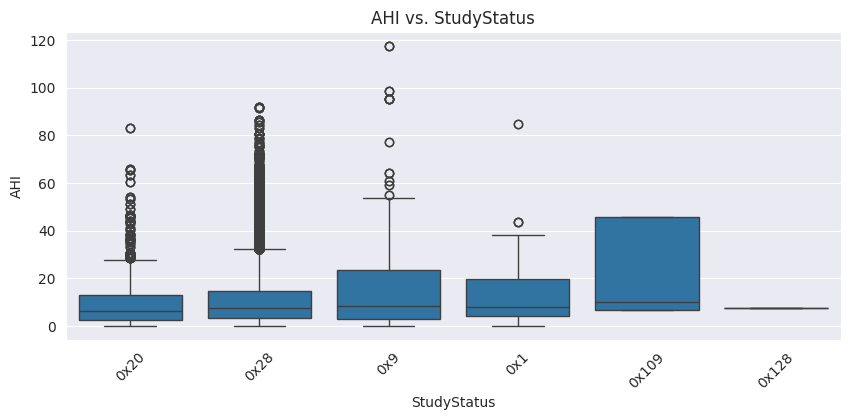

In [97]:
# In [6]:  Boxplot of AHI grouped by StudyStatus
# Filter StudyStatus values that have AHI data points
valid_statuses = df_sleep.groupby('StudyStatus')['AHI'].count()
valid_statuses = valid_statuses[valid_statuses > 0].index

# Plot only the valid statuses
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_sleep[df_sleep['StudyStatus'].isin(valid_statuses)], x='StudyStatus', y='AHI')
plt.title('AHI vs. StudyStatus')
plt.xticks(rotation=45)  # Rotate for readability if needed
plt.show()



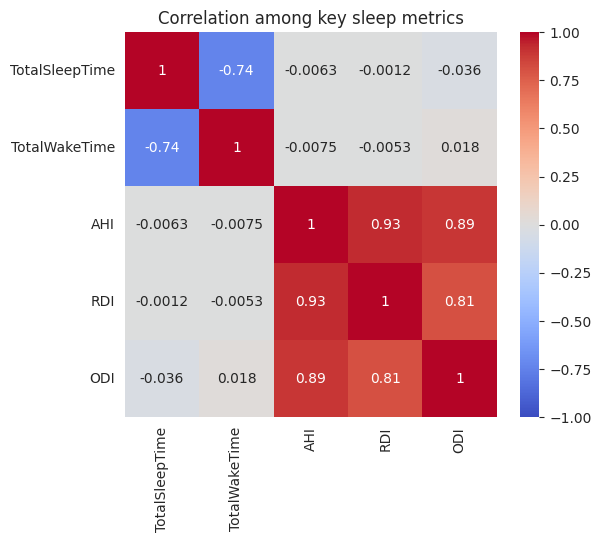

In [98]:
# In [7]:  Correlation heatmap of selected numeric columns
plt.figure(figsize=(6,5))
cols_of_interest = ['TotalSleepTime','TotalWakeTime','AHI','RDI','ODI']
corr = df_sleep[cols_of_interest].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation among key sleep metrics')
plt.show()



In [99]:
df_datapoint_n = df_sleep['RegistrationCode'].value_counts().reset_index()
df_datapoint_n.columns = ['RegistrationCode', 'numbers']

# Sort the dataframe by 'numbers' in descending order
df_datapoint_n = df_datapoint_n.sort_values(by='numbers', ascending=False)

# Print the max and min
max_count = df_datapoint_n['numbers'].max()
min_count = df_datapoint_n['numbers'].min()
unique_ids = df_datapoint_n.shape[0]

print(f"Max count: {max_count}")
print(f"Min count: {min_count}")
print(f"Unique IDs: {unique_ids}")


Max count: 36
Min count: 1
Unique IDs: 8275


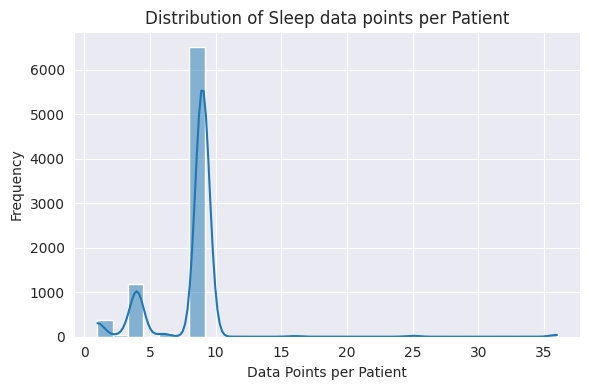

In [100]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_datapoint_n, x='numbers', bins=30, kde=True)
plt.title('Distribution of Sleep data points per Patient')
plt.xlabel('Data Points per Patient')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Continuos Glucose Monitor (CGM)

CGM loader contains raw data of cgm sensors that are connected to participants for 2 weeks after the meeting

In [101]:
cgm =CGMLoader().get_data()
df_cgm = cgm.df

In [102]:
df_cgm = df_cgm.reset_index()
df_datapoint_n = df_cgm['RegistrationCode'].value_counts().reset_index()
df_datapoint_n.columns = ['RegistrationCode', 'numbers']

# Sort the dataframe by 'numbers' in descending order
df_datapoint_n = df_datapoint_n.sort_values(by='numbers', ascending=False)

# Print the max and min
max_count = df_datapoint_n['numbers'].max()
min_count = df_datapoint_n['numbers'].min()
unique_ids = df_datapoint_n.shape[0]

print(f"Max count: {max_count}")
print(f"Min count: {min_count}")
print(f"Unique IDs: {unique_ids}")


Max count: 23086
Min count: 78
Unique IDs: 12904


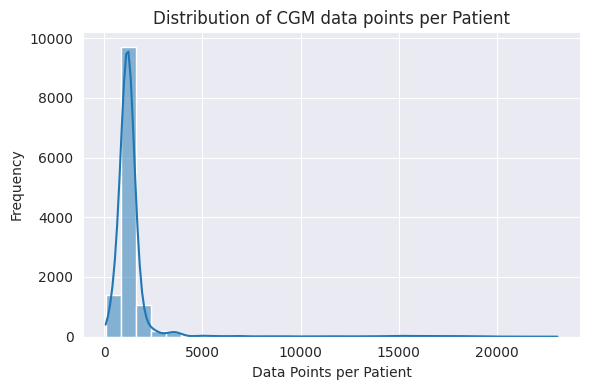

In [103]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_datapoint_n, x='numbers', bins=30, kde=True)
plt.title('Distribution of CGM data points per Patient')
plt.xlabel('Data Points per Patient')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

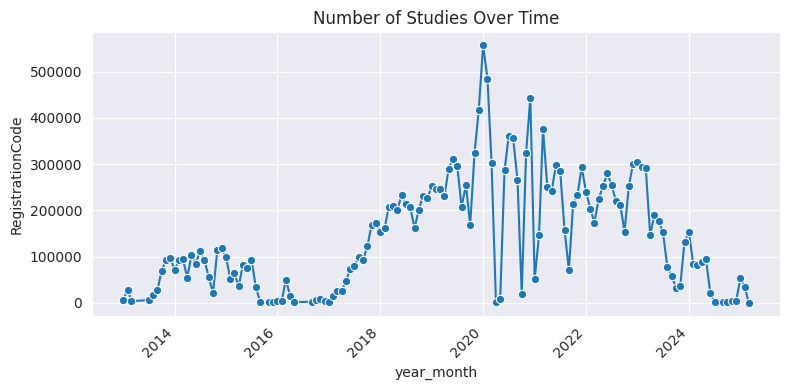

In [104]:
df_cgm = df_cgm.reset_index()
df_cgm['Date'] = pd.to_datetime(df_cgm['Date'], errors='coerce')

# Convert to period and then to timestamp (representing the first day of the month)
df_cgm['year_month'] = df_cgm['Date'].dt.to_period('M').dt.to_timestamp()

# Group by the new column and count the number of RegistrationCode entries per month
counts = df_cgm.groupby('year_month')['RegistrationCode'].count().reset_index()

# Plot the lineplot with proper rotation for clarity
plt.figure(figsize=(8,4))
sns.lineplot(data=counts, x='year_month', y='RegistrationCode', marker='o')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Studies Over Time')
plt.tight_layout()
plt.show()

In [105]:
df_sleep.head(3)

,RegistrationCode,night,Date,StudyStatus,Warnings,BraceletMessage,StudyStartTime,StudyEndTime,TotalApneaSleepTime,TotalAH_CentralValidSleepTime,...,PhysicalSleepTime,PhysicalWakeTime,%DeepSleep,%REM,%LightSleep,%Wake,%Sleep,StudyStatus_filled,year_month,gender
0,10K_1000942861,1.0,2021-12-16 23:14:24,0x20,NaN,NaN,83664.0,40464.0,28015.0,NaN,...,2021-12-16 23:26:19.231788079,2021-12-17 08:07:45.854304635,18.684838,25.833541,55.481621,34.946759,65.053241,0x20,2021-12-01,M
1,10K_1000942861,1.0,2021-12-16 23:14:24,0x20,NaN,NaN,83664.0,40464.0,28015.0,NaN,...,2021-12-16 23:26:19.231788079,2021-12-17 08:07:45.854304635,18.684838,25.833541,55.481621,34.946759,65.053241,0x20,2021-12-01,M
2,10K_1000942861,2.0,2021-12-25 22:54:26,0x20,NaN,NaN,82466.0,39266.0,25885.0,NaN,...,2021-12-25 23:03:58.185430463,2021-12-26 08:16:11.298013245,17.777013,29.583763,52.639223,39.437500,60.562500,0x20,2021-12-01,M


In [106]:
df_cgm.head(3)

,index,RegistrationCode,ConnectionID,Date,GlucoseValue,PPGR,year_month
0,0,-1,1,2013-01-21 14:20:50,88.0,0.0,2013-01-01
1,1,-1,1,2013-01-21 14:25:50,89.0,0.0,2013-01-01
2,2,-1,1,2013-01-21 14:30:50,87.0,0.0,2013-01-01


In [107]:

# 1) Ensure dates are datetime
df_sleep['Date'] = pd.to_datetime(df_sleep['Date'], errors='coerce')
df_cgm['Date']   = pd.to_datetime(df_cgm['Date'], errors='coerce')

# 2) Merge on RegistrationCode
merged = pd.merge(
    df_sleep[['RegistrationCode', 'Date']],
    df_cgm[['RegistrationCode', 'Date']],
    on='RegistrationCode',
    how='inner',
    suffixes=('_sleep','_cgm')
)

# 3) Compute absolute difference in days
merged['date_diff_days'] = (
    (merged['Date_sleep'] - merged['Date_cgm']).abs().dt.days
)

# 4) Filter to keep only rows with <= 2 days difference
filtered = merged[merged['date_diff_days'] <= 2]

# 5) Group by RegistrationCode and count how many overlaps
df_sleep_cgm_count = (
    filtered.groupby('RegistrationCode')
            .size()
            .reset_index(name='overlap_count')
)


In [108]:
df_sleep_cgm_count.head()

,RegistrationCode,overlap_count
0,10K_1000942861,1912
1,10K_1002254441,4755
2,10K_1003113258,1604
3,10K_1007330152,5184
4,10K_1008294272,3495


In [109]:
# Print the max and min
max_count = df_sleep_cgm_count['overlap_count'].max()
min_count = df_sleep_cgm_count['overlap_count'].min()
unique_ids = df_sleep_cgm_count.shape[0]

print(f"Max count: {max_count}")
print(f"Min count: {min_count}")
print(f"Unique IDs: {unique_ids}")

Max count: 16566
Min count: 15
Unique IDs: 5718


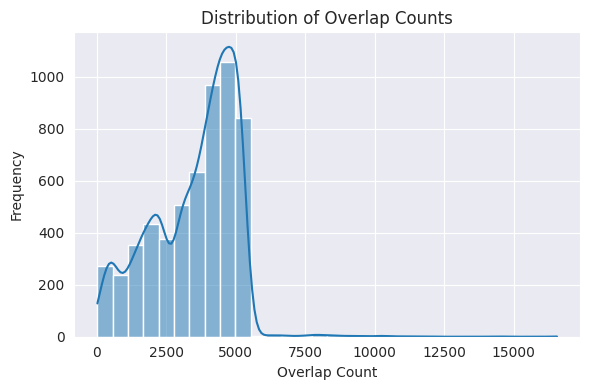

In [110]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_sleep_cgm_count, x='overlap_count', bins=30, kde=True)
plt.title('Distribution of Overlap Counts')
plt.xlabel('Overlap Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

We need to create the embeddings from the medical data of each patient, and from the sleep and glucose data. Let's start from the medical data

In [111]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    # Use the CLS token representation as the embedding:
    embedding = outputs.last_hidden_state[:, 0, :]
    return embedding
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [112]:
sample_text = "Patient exhibits signs of mild sleep apnea and elevated blood glucose."
sample_text_1 = "The patients cannot sleep well, eats a lot of sugary food, and has reported heavy snoring"
sample_text_2 = "The patient is all good"
embedding = get_embedding(sample_text)
embedding_1 = get_embedding(sample_text_1)
embedding_2 = get_embedding(sample_text_2)
print(embedding.shape)
print(embedding_1.shape)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([1, 768])
torch.Size([1, 768])


## Medical Condition Analysis

MedicalConditionLoader contains medical conditions reported throught the surveys and to the coordinators in the clinic
the date is approximation of the start of the condition, the main data is ICD11 code (df_columns_metadata contains translation of this ICD11 code)

In [123]:
medical_condition = MedicalConditionLoader().get_data().df
medical_condition_columns_metadata = MedicalConditionLoader().get_data().df_columns_metadata
medical_condition.head(3)


ValueError: unconverted data remains when parsing with format "%Y-%m-%d %H:%M:%S": ".340337", at position 2. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [128]:
fam_medical_condition = FamilyMedicalConditionsLoader().get_data().df
fam_medical_condition_columns_metadata = FamilyMedicalConditionsLoader().get_data().df_columns_metadata
fam_medical_condition.head(3)

/tmp/ipykernel_230869/2967645717.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return original_to_datetime(arg, format=format, **kwargs)


AttributeError: 'Index' object has no attribute 'year'

get_data arguments:
relevant study_ids = [10, 1001, 1002] ----1001 - beilinson ---1002 - cancer relevant research stages = ['baseline','00_01_visit', '00_02_visit','01_00_call','01_01_visit','02_00_visit', '02_01_visit','02_02_visit','03_00_call','03_00_visit','03_01_visit']

In [5]:
study_ids = [10, 1001, 1002]
SubjectLoader().get_data(study_ids=study_ids).df.head(3)

,,StudyTypeID,city,country,gender,month_of_birth,us_state,yob,StudyTypeID2,StudyTypeID3,StudyTypeID4,StudyTypeID5,StudyTypeID6,StudyTypeID7,StudyTypeID8,StudyTypeID9,age,tz
RegistrationCode,Date,,,,,,,,,,,,,,,,,
10K_1000028368,2020-03-22 08:26:05.077073,10.0,None,IL,1.0,9,None,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,Asia/Jerusalem
10K_1000273395,2020-03-05 20:53:54.399388,10.0,None,IL,1.0,3,None,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,Asia/Jerusalem
10K_1000633050,2021-06-21 14:23:50.372010,10.0,None,IL,0.0,7,None,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,Asia/Jerusalem


In [17]:
bm = BodyMeasuresLoader().get_data(study_ids=study_ids).df.join(BodyMeasuresLoader().get_data(study_ids=study_ids).df_metadata)

general_info = bm.reset_index().set_index('RegistrationCode')
general_info = general_info[~general_info['gender'].isna()]
general_info = general_info[~general_info['age'].isna()]

gender_dictionary = {1:'male', 0:'female'}

general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)

general_info.head(10)

/tmp/ipykernel_14947/1518352966.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['male' 'female' 'female' ... 'male' 'male' 'female']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)


,Date,dizziness,neck_circumference,fingers_grip_right,body_fat,fingers_grip_left,weight,standing_one_min_blood_pressure_systolic,bmr,sitting_blood_pressure_systolic,...,StudyTypeID2,blood_pressure_hand,city,source_created_at,country,StudyTypeID,yob,sitting_another_hand_blood_pressure_pulse_rate,second_hand_grip_left,second_hand_grip_right
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,2021-12-13 07:09:38.954985,False,NaN,NaN,NaN,NaN,91.800003,145.0,NaN,NaN,...,NaN,NaN,רחובות,2021-12-13 07:09:38.954985+00:00,IL,10.0,1967.0,NaN,NaN,NaN
10K_1001201093,2021-08-26 07:39:21.411519,False,NaN,NaN,NaN,NaN,59.400002,103.0,NaN,104.0,...,NaN,NaN,ראשון לציון,2021-08-26 07:39:21.411519+00:00,IL,10.0,1979.0,NaN,NaN,NaN
10K_1001201093,2023-09-12 10:23:05.534125,NaN,29.0,NaN,NaN,NaN,58.799999,NaN,NaN,107.0,...,NaN,Left,ראשון לציון,2023-09-12 10:23:05.534125+00:00,IL,10.0,1979.0,73.0,65.0,75.0
10K_1002033709,2022-08-03 07:20:01.044769,True,34.0,NaN,NaN,NaN,55.000000,102.0,NaN,102.0,...,NaN,Left,תל אביב-יפו,2022-08-03 07:20:01.044769+00:00,IL,10.0,1979.0,NaN,NaN,NaN
10K_1002087123,2019-12-04 11:53:40.350115,False,NaN,NaN,45.099998,NaN,105.699997,135.0,1805.0,145.0,...,NaN,NaN,תל אביב-יפו,2019-12-04 11:53:40.350115+00:00,IL,10.0,1977.0,NaN,NaN,NaN
10K_1002087123,2022-03-22 11:42:27.565348,False,NaN,NaN,NaN,NaN,98.500000,147.0,NaN,129.0,...,NaN,NaN,תל אביב-יפו,2022-03-22 11:42:27.565348+00:00,IL,10.0,1977.0,NaN,NaN,NaN
10K_1002254441,2022-09-15 07:00:31.408388,False,35.5,NaN,NaN,NaN,74.000000,114.0,NaN,107.0,...,NaN,Left,רמת גן,2022-09-15 07:00:31.408388+00:00,IL,10.0,1977.0,NaN,NaN,NaN
10K_1002254441,2025-02-13 06:20:52.699166,NaN,37.0,NaN,NaN,NaN,76.900002,NaN,NaN,128.0,...,NaN,Left,רמת גן,2025-02-13 06:20:52.699166+00:00,IL,10.0,1977.0,60.0,100.5,93.9
10K_1003113258,2020-02-09 12:38:07.180299,False,NaN,NaN,36.599998,NaN,89.800003,145.0,1980.0,144.0,...,NaN,NaN,בנימינה-גבעת עדה,2020-02-09 12:38:07.180299+00:00,IL,10.0,1971.0,NaN,NaN,NaN


In [18]:
general_info.shape

(21188, 65)

In [20]:
general_info = general_info.reset_index()

In [22]:
# Count the number of unique RegistrationCodes
unique_count = general_info['RegistrationCode'].nunique()

# Calculate the frequency for each unique RegistrationCode
frequency_series = general_info['RegistrationCode'].value_counts()

# Compute the average and median frequencies
average_frequency = frequency_series.mean()
median_frequency = frequency_series.median()

print("Unique RegistrationCodes:", unique_count)
print("Average frequency per RegistrationCode:", average_frequency)
print("Median frequency per RegistrationCode:", median_frequency)


Unique RegistrationCodes: 12222
Average frequency per RegistrationCode: 1.7335951562755687
Median frequency per RegistrationCode: 2.0


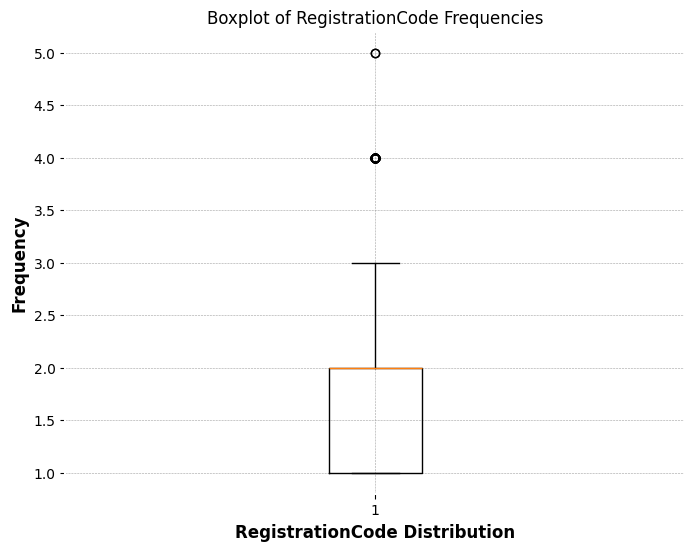

In [24]:
plt.figure(figsize=(8, 6))
plt.boxplot(frequency_series, vert=True)
plt.xlabel('RegistrationCode Distribution')
plt.ylabel('Frequency')
plt.title('Boxplot of RegistrationCode Frequencies')
plt.show()



In [25]:
# Count how many RegistrationCodes have frequencies of 1 through 5
frequency_counts = frequency_series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Display the results
for freq, count in frequency_counts.items():
    print(f"Number of RegistrationCodes with frequency {freq}: {count}")

Number of RegistrationCodes with frequency 1: 5353
Number of RegistrationCodes with frequency 2: 4850
Number of RegistrationCodes with frequency 3: 1943
Number of RegistrationCodes with frequency 4: 74
Number of RegistrationCodes with frequency 5: 2


In [19]:
path_file = '/net/mraid20/export/genie/LabData/Data/10K/for_review/'
file_name = 'follow_up_conditions_all.csv'
file_name_1 = 'baseline_conditions_all.csv'
full_path = path_file + file_name
full_path_1 = path_file + file_name_1

# Read the CSV file into a DataFrame
df_conditions_follow_up = pd.read_csv(full_path)
df_conditions_baseline = pd.read_csv(full_path_1)

# Display the first few rows of the DataFrame
df_conditions_follow_up.head()

,RegistrationCode,medical_condition,index,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,Baseline_Date
0,10K_1001201093,RA01,560,2022-05-01 00:00:00.000000,True,קורונה,2022-08-02 05:48:59.526988+00:00,01_00_call,Infectious Disease,COVID-19,COVID-19,2021-08-26 07:39:21.411519
1,10K_1002087123,DA63,562,2021-01-01 00:00:00.000000,True,כיב בתריסריון (DA63),2022-03-22 12:42:01.880301+00:00,02_00_visit,Gastro,Peptic Ulcer Disease,Duodenal ulcer,2019-12-04 11:53:40.350115
2,10K_1002087123,GB70,561,2021-01-01 00:00:00.000000,True,אבנים בכליות (GB70),2022-03-22 12:42:01.880301+00:00,02_00_visit,Urology,Renal stones,Calculus of upper urinary tract,2019-12-04 11:53:40.350115
3,10K_1002087123,RA01,563,2022-12-06 00:00:00.000000,True,קורונה,2023-01-23 08:41:22.433394+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2019-12-04 11:53:40.350115
4,10K_1007330152,RA01,564,2023-01-01 00:00:00.000000,True,קורונה,2023-11-12 06:33:59.308045+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2020-11-16 12:25:48.195845


In [13]:
df_conditions_baseline.head()

,RegistrationCode,medical_condition,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,index,Baseline_Date
0,10K_1000942861,BlockL2-6A7,2008-01-01,True,דיכאון,2021-06-11 11:51:55,baseline,Neurologic,Depression,Depressive disorders,NaN,NaN
1,10K_1000942861,DB60,2000-01-01,True,טחורים,2021-06-11 11:51:55,baseline,Surgery,Haemorrhoids,Haemorrhoids,NaN,NaN
2,10K_1000942861,RA01,2020-12-23,True,קורונה,2023-12-25 12:52:12.534390+00:00,baseline,Infectious Disease,COVID-19,COVID-19,NaN,NaN
3,10K_1002033709,ED80,2000-01-01,True,אקנה,2022-01-11 07:16:11.594000,baseline,Dermatology,Allergy,Acne,NaN,NaN
4,10K_1002033709,GC08.Z,2000-01-01,True,דלקת בשתן,2022-01-11 07:16:11.594000,baseline,Urology,Urinary tract infection,"Urinary tract infection, site and agent not sp...",NaN,NaN


In [14]:
df_conditions_baseline['english_name'].value_counts()

english_name
Hyperlipoproteinaemia                       2535
Haemorrhoids                                2432
Spinal pain                                 2331
Attention deficit hyperactivity disorder    2196
Allergic rhinitis                           1391
                                            ... 
Acute pericarditis                             1
Fracture of shoulder or upper arm              1
Non-alcoholic steatohepatitis                  1
Horner syndrome                                1
Tourette syndrome                              1
Name: count, Length: 427, dtype: int64

In [15]:
df_conditions_follow_up['english_name'].value_counts()

english_name
COVID-19                                                                                   6157
Hyperlipoproteinaemia                                                                       382
Essential hypertension                                                                      219
Intermediate hyperglycaemia                                                                 196
Other specified conditions associated with the spine (intervertebral disc displacement)      91
                                                                                           ... 
Perforation of tympanic membrane                                                              1
Essential tremor or related tremors                                                           1
Spondylolisthesis                                                                             1
Pericardial effusion                                                                          1
Allergic rhinitis          

In [17]:
df_conditions_baseline['research_stage'].value_counts()

research_stage
baseline       38725
01_00_call        15
02_00_visit        6
Name: count, dtype: int64

In [18]:
df_conditions_follow_up['research_stage'].value_counts()

research_stage
01_00_call     3901
02_00_visit    2233
03_00_call     2109
04_00_visit     384
05_00_call      203
04_01_call       48
02_01_call       42
01_01_visit       5
06_00_visit       3
01_01_call        2
00_01_visit       1
03_01_visit       1
Name: count, dtype: int64

In [25]:
common_codes = pd.merge(df_conditions_baseline[['RegistrationCode']],
                           df_conditions_follow_up[['RegistrationCode']],
                           on='RegistrationCode',
                           how='inner')['RegistrationCode'].unique().tolist()

len(common_codes)

5983

In [23]:
df_conditions_baseline[df_conditions_baseline['RegistrationCode'] == common_codes[0]]

,RegistrationCode,medical_condition,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,index,Baseline_Date
5,10K_1002087123,6A05,2000-01-01,True,הפרעות קשב וריכוז,2019-10-25 12:55:22,baseline,Neurologic,Attention Deficit Disorder (ADHD),Attention deficit hyperactivity disorder,NaN,NaN
6,10K_1002087123,BA00,2000-01-01,True,יתר לחץ דם,2019-10-25 12:55:22,baseline,Cardiovascular,Hypertension,Essential hypertension,NaN,NaN


In [24]:
df_conditions_follow_up[df_conditions_follow_up['RegistrationCode'] == common_codes[0]]

,RegistrationCode,medical_condition,index,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,Baseline_Date
1,10K_1002087123,DA63,562,2021-01-01 00:00:00.000000,True,כיב בתריסריון (DA63),2022-03-22 12:42:01.880301+00:00,02_00_visit,Gastro,Peptic Ulcer Disease,Duodenal ulcer,2019-12-04 11:53:40.350115
2,10K_1002087123,GB70,561,2021-01-01 00:00:00.000000,True,אבנים בכליות (GB70),2022-03-22 12:42:01.880301+00:00,02_00_visit,Urology,Renal stones,Calculus of upper urinary tract,2019-12-04 11:53:40.350115
3,10K_1002087123,RA01,563,2022-12-06 00:00:00.000000,True,קורונה,2023-01-23 08:41:22.433394+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2019-12-04 11:53:40.350115


In [28]:
# Merge DataFrames on 'RegistrationCode' and 'english_name' to find common records
common_conditions = pd.merge(df_conditions_baseline, df_conditions_follow_up, on=['RegistrationCode', 'english_name'], how='inner')['RegistrationCode'].nunique()


# Display the result
print(f"Number of patients with the same disease in both DataFrames: {common_conditions}")

Number of patients with the same disease in both DataFrames: 5


In [30]:
pd.merge(df_conditions_baseline, df_conditions_follow_up, on=['RegistrationCode', 'english_name'], how='inner')

,RegistrationCode,medical_condition_x,Date_x,Start_x,name_x,created_at_x,research_stage_x,Group_x,Consolidated name_x,english_name,...,medical_condition_y,index_y,Date_y,Start_y,name_y,created_at_y,research_stage_y,Group_y,Consolidated name_y,Baseline_Date_y
0,10K_2842497388,BlockL2-6A7,2023-01-01,True,דיכאון,2023-12-19 04:02:52.950523+00:00,baseline,Neurologic,Depression,Depressive disorders,...,6A7,2935,2024-01-01 00:00:00.000000,True,דיכאון (6A7),2024-11-25 16:40:54.433800+00:00,01_00_call,Neurologic,Depression,2023-12-18 07:07:55.605764
1,10K_5904281650,BlockL2-FA0,2000-01-01,True,אוסטאוארטריטיס,2020-02-06 14:21:20,baseline,Rheumatology,Osteoarthritis,Osteoarthritis,...,FA0,7020,2021-01-01 00:00:00.000000,True,אוסטאוארטריטיס (FA0),2023-07-09 07:54:47.912081+00:00,01_00_call,Rheumatology,Osteoarthritis,2020-06-23 10:14:23.788501
2,10K_6205511815,BlockL1-3A0,2000-01-01,True,אנמיה,2021-03-19 14:34:10,baseline,Hematological,Anemia,Anaemias or other erythrocyte disorders,...,3A0,7417,2023-01-01 00:00:00.000000,True,אנמיה (3A0),2023-06-20 11:08:48.345285+00:00,02_00_visit,Hematological,Anemia,2021-05-26 07:38:06.029521
3,10K_9249892338,BlockL2-6A7,2010-01-01 00:00:00.000000,True,דיכאון,2020-08-19 12:58:02,baseline,Neurologic,Depression,Depressive disorders,...,6A7,11375,2024-07-01 00:00:00.000000,True,דיכאון (6A7),2024-11-14 08:05:27.592965+00:00,04_00_visit,Neurologic,Depression,2020-08-25 10:27:33.462690
4,10K_9626336152,BA80,2000-01-01 00:00:00.000000,True,מחלת עורקים כלילית (BA80),2024-12-23 15:27:13.627000+00:00,baseline,Cardiovascular,Atherosclerotic disease,Coronary atherosclerosis,...,BA52,11888,2024-09-01 00:00:00.000000,True,טרשת עורקים בעורקי הלב הכליליים (קורונארים),2024-12-23 15:27:13.627000+00:00,03_00_call,Cardiovascular,Ischemic Heart Disease,2022-01-06 11:08:17.819071
